# Backtesting the AI Investor
Chapter 6 of the book: "Build Your Own AI Investor"

In [1]:


import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [2]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [3]:
from platform import python_version
print(python_version())

3.9.7


In [4]:
def loadXandyAgain(randRows=True):
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv('Annual_Stock_Price_Fundamentals_Ratios.csv',
                  index_col=0)
    y=pd.read_csv('Annual_Stock_Price_Performance_Percentage.csv',
                  index_col=0)
    y=y['Perf'] # We only need the % returns as target
    
    if randRows:
        # randomize the rows
        X['y'] = y
        X = X.sample(frac=1.0, random_state=42) # randomize the rows
        y = X['y']
        X.drop(columns=['y'], inplace=True)

    return X, y

In [5]:
def createYDataForBacktest(y_test):
    '''
    The backtester needs dates from the old y vector.
    This creates a new y DataFrame containing those dates.
    '''
    # Annual stock performances, with date data.
    y_withData=pd.read_csv('Annual_Stock_Price_Performance_Filtered.csv', 
                           index_col=0)

    # Convert to date
    y_withData['Date'] = pd.to_datetime(y_withData['Date'])
    y_withData['Date2'] = pd.to_datetime(y_withData['Date2'])

    # Get y_withData to correspond to y_test
    y_withData_Test=pd.DataFrame()
    y_withData_Test=y_withData.loc[y_test.index, :]

    # Convert string to datetime
    y_withData_Test['Date'] = pd.to_datetime(y_withData_Test['Date'])
    y_withData_Test['Date2'] = pd.to_datetime(y_withData_Test['Date2'])
    
    return y_withData, y_withData_Test

In [6]:
from sklearn.model_selection import train_test_split

def getNewDataForBacktest(random_state=42):
    '''
    Create all the data for a backtest:
    X_train, X_test, y_train, y_test, y_withData, y_withData_Test.
    
    reads files: Annual_Stock_Price_Fundamentals_Ratios.csv,
    Annual_Stock_Price_Performance_Percentage.csv,
    Annual_Stock_Price_Performance_Filtered.csv.
    
    Set a random_state to control the train/test split. Default 42.
    '''
    X, y = loadXandyAgain()
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=random_state)
    y_withData, y_withData_Test = createYDataForBacktest(y_test)
    
    return X_train, X_test, y_train, y_test, y_withData, y_withData_Test

In [7]:
X_train, X_test, y_train, y_test, y_withData, y_withData_Test = getNewDataForBacktest(42)

In [8]:
X_train.head()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
15608,25.088187,1.892463,30.787803,100.000000,8.309345,15.365672,0.992100,4.395644,0.336493,25.609800,1.039048,0.500176,7.920565,0.859817,-0.003069,0.000955,0.205770,0.039048
12984,10.091484,0.438757,10.106306,-9.710831,0.663155,4.345765,2.351683,-0.960868,0.265582,0.000000,0.886492,0.157368,12.753286,0.494439,0.316537,-0.085707,0.203388,-0.113508
4585,9.675629,-4.787856,13.771049,4.669563,1.621880,8.677293,0.651565,0.339086,0.295852,1.851320,1.540155,0.247085,15.638219,0.645944,-0.108796,0.325538,0.203475,0.540155
11795,19.068705,0.242455,26.734055,6.676976,2.934750,-600.000000,2.836232,0.249755,0.226205,0.875714,2.141925,1.004400,2.292363,0.518336,0.274266,-0.272696,0.192419,1.141925
12516,-9.524490,-0.016296,-0.393110,0.760208,0.212104,-0.133581,0.219967,-1.933832,-0.094018,15.350187,1.065146,0.065568,0.285433,1.000000,-0.284727,-1.175022,-0.059700,0.065146


In [9]:
X_test.head()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
1933,27.984892,0.415935,44.854289,7.318737,3.974482,17.444196,3.330784,0.163167,0.109558,1.821541,1.548986,1.562154,7.445341,0.621314,0.281290,-0.013804,0.096336,0.548986
11215,11.522145,0.196645,17.770079,2.034452,1.127335,12.321385,1.826463,0.114488,0.151735,0.780235,2.281665,0.022093,2.807647,0.479987,0.210725,0.345108,0.113047,1.281665
12225,500.000000,-0.006468,15.567165,2.966159,3.037539,-1.311360,5.591371,0.190539,0.000995,0.177743,6.626086,4.124435,14.096315,0.499838,0.620849,-0.598089,0.000860,5.626086
9258,14.829516,0.121908,26.601143,1.880889,0.372590,2.615108,1.542358,0.070707,0.063131,3.577692,1.279510,0.377857,2.470706,0.405126,0.113615,0.104554,0.049906,0.279510
13616,33.416985,1.148434,100.366490,4.179117,5.030074,-600.000000,1.042428,0.041639,0.101287,0.645387,2.549459,0.649495,10.243371,0.759922,0.012691,0.397277,0.070991,1.549459


In [10]:
y_test.head() # y targets

1933     0.075202
11215    0.404996
12225    0.329741
9258     0.147485
13616   -0.002599
Name: y, dtype: float64

In [11]:
y_withData_Test.head() # y data corresponding to y targets

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
1933,BCR,174.73,2015-02-18,6.629396e+07,BCR,187.87,2016-02-18,6.913860e+07
11215,ORLY,39.63,2010-02-26,6.349915e+07,ORLY,55.68,2011-02-28,8.012352e+07
12225,QTNA,13.92,2018-02-28,4.506739e+06,QTNA,18.51,2019-02-28,7.614551e+06
9258,M,20.68,2010-03-10,2.197043e+08,M,23.73,2011-03-10,1.592093e+08
13616,SNPS,88.50,2017-12-14,8.453786e+07,SNPS,88.27,2018-12-14,9.841231e+07


In [12]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData(directory='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices['Date'])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (6567888, 11)


# Train a model from here for backtest
Otherwise train a model in previous notebook, where data will be loaded into this notebook.

We select stocks in a backtest with a picked, pretrained model.

The the train set trains the mdoel the test set is sent to the backtester.

In [13]:
X_train, X_test, y_train, y_test, y_withData, y_withData_Test = getNewDataForBacktest(41)

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle # To save the fitted model

pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())]).fit(X_train, y_train)

y_pred = pl_linear.predict(X_test)

print('train mse: ', 
      mean_squared_error(y_train, pl_linear.predict(X_train)))
print('test mse: ',
      mean_squared_error(y_test, y_pred))

pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

train mse:  0.408088796948429
test mse:  0.34552842055426763


Or can use Random Forest

In [55]:
X_train, X_test, y_train, y_test, y_withData, y_withData_Test = getNewDataForBacktest(42)

# Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfregressor = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(rfregressor, open("rfregressor.p", "wb" ))

train mse:  0.20582791501796052
test mse:  0.5841730014206696


# Backtest Program

In [15]:
def getStockPriceBetweenDates(date1, date2, ticker, 
                              daily_stock_prices):
#     # Alternative way
#     rows = daily_stock_prices[(daily_stock_prices["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (daily_stock_prices["Ticker"]==ticker)]
    newRows = pd.DataFrame()
    newRows = daily_stock_prices.loc[(daily_stock_prices["Date"]>date1) &\
                                  (daily_stock_prices["Date"]<date2) &\
                                  (daily_stock_prices["Ticker"]==ticker)]
    newRows.set_index('Date', inplace=True)
    return newRows

In [16]:
getStockPriceBetweenDates('2018-03-01', '2019-03-01', 
                          'AAPL', daily_stock_prices_data).head()

,Ticker,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
Date,,,,,,,,,,
2018-03-02,AAPL,111052,43.20,43.11,44.08,44.05,42.50,NaN,38453950,2.029605e+10
2018-03-05,AAPL,111052,43.80,43.63,44.44,44.20,42.64,NaN,28401366,2.029605e+10
2018-03-06,AAPL,111052,44.48,44.03,44.56,44.17,42.61,NaN,23788506,2.029605e+10
2018-03-07,AAPL,111052,43.73,43.57,43.96,43.76,42.21,NaN,31703462,2.029605e+10
2018-03-08,AAPL,111052,43.87,43.77,44.28,44.23,42.67,NaN,23163767,2.029605e+10


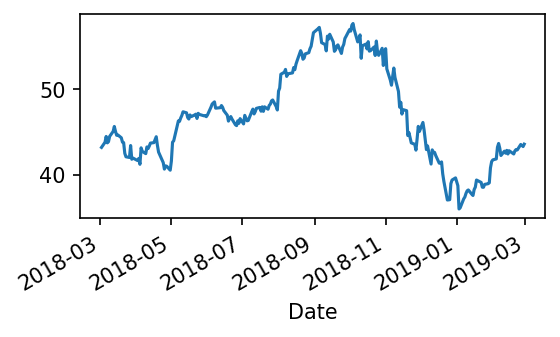

In [17]:
getStockPriceBetweenDates('2018-03-01', '2019-03-01', 
                          'AAPL', 
                          daily_stock_prices_data)['Open'].plot(figsize=(4,2));

In [18]:
def getDataForDateRange(weeklyDateTimeIndex, dailyStockDataRows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    weeklyStockDataRows = pd.DataFrame()
    for weeklyDate in weeklyDateTimeIndex:
        weeklyStockDataRows = pd.concat([weeklyStockDataRows, 
                                         dailyStockDataRows.iloc[dailyStockDataRows.index.get_indexer([weeklyDate],
                                                                                                      method='nearest')]
                                        ])
    return weeklyStockDataRows

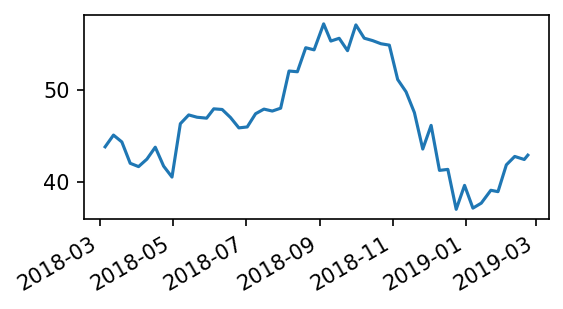

In [19]:
weeklyDateTimeIndex = pd.date_range(start='2018-03-01', 
                                    periods=52, 
                                    freq='W')

dailyPriceData = getStockPriceBetweenDates(weeklyDateTimeIndex[0], 
                                           weeklyDateTimeIndex[-1], 
                                           'AAPL', 
                                           daily_stock_prices_data)

getDataForDateRange(weeklyDateTimeIndex, dailyPriceData)['Open'].plot(figsize=(4,2));

In [20]:
def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame for a list of tickers,
    over a dataTimeIndex.
    dateTimeIndex is typically a weekly index.
    '''
    stocksPrices = pd.DataFrame(index=dateTimeIndex)
    weeklyDateTimeIndex = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    
    # For a range of stocks
    for ticker in tickers:
        # For each individual stock
        dailyStockDataRows = getStockPriceBetweenDates(dateTimeIndex[0], 
                                                       dateTimeIndex[-1], 
                                                       ticker, 
                                                       daily_stock_prices)

        weeklyStockDataRows = getDataForDateRange(weeklyDateTimeIndex,
                                                  dailyStockDataRows)
        
        # Append each stock data to the DataFrame
        # Here can use Open, Close, Adj. Close, etc. price
        stocksPrices[ticker] = weeklyStockDataRows["Close"].values
    return stocksPrices

In [21]:
weeklyDateTimeIndex = pd.date_range(start='2019-03-01', 
                                    periods=52, 
                                    freq='W')

stocksPrices = getStockTimeSeries(weeklyDateTimeIndex, 
                                  y_withData, 
                                  ['AAPL', 'MSFT','TSLA'], 
                                  daily_stock_prices_data)

stocksPrices.head()

,AAPL,MSFT,TSLA
2019-03-03,43.96,112.26,57.07
2019-03-10,44.73,112.83,58.18
2019-03-17,47.01,117.57,53.90
2019-03-24,47.19,117.66,52.08
2019-03-31,47.81,119.02,57.84


In [22]:
def getPortfolioRelativeTimeSeries(stocksPrices):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stocksPrices.keys():
        stocksPrices[key]=stocksPrices[key]/stocksPrices[key][0]
    stocksPrices["Portfolio"] = stocksPrices.sum(axis=1)/\
                                    (stocksPrices.keys().shape[0])
    return stocksPrices

In [23]:
getPortfolioRelativeTimeSeries(stocksPrices).head()

,AAPL,MSFT,TSLA,Portfolio
2019-03-03,1.000000,1.000000,1.000000,1.000000
2019-03-10,1.017516,1.005077,1.019450,1.014014
2019-03-17,1.069381,1.047301,0.944454,1.020379
2019-03-24,1.073476,1.048103,0.912564,1.011381
2019-03-31,1.087580,1.060217,1.013492,1.053763


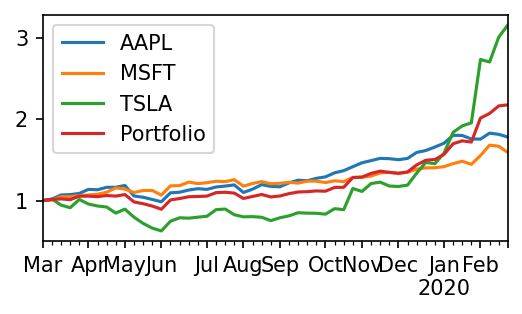

In [24]:
getPortfolioRelativeTimeSeries(stocksPrices).plot(figsize=(4,2));

In [25]:
# Z score to account for default chance
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

z = calcZScores(X_test)
z.head()

,Z score
1933,6.260011
11215,7.852296
12225,11.255126
9258,4.959334
13616,6.731733


In [26]:
def getYPerf(y_):
    '''
    To get the y_withData to line up the the Ticker ID
    To get the Ticker ID later
    '''
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [84]:
def getPortTimeSeriesForYear(date_starting, 
                             y_withData, 
                             X, 
                             daily_stock_prices, 
                             ml_model_pipeline,
                             verbose=False):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # To get the Ticker ID later
    y_TickerList = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) )
    if verbose:
        print('Selecting stocks with financial data published between:\n', 
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),
              'and', pd.to_datetime(date_starting),
              'To hold for 1 year.')
    
    if verbose:
        print('Stock Selection from', X[thisYearMask].shape[0], 'stocks')
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
       
    # Make a DataFrame to select the top picks
    StockSelectionDF = pd.DataFrame()
    
    StockSelectionDF['ZScore'] = calcZScores(X[thisYearMask])
    StockSelectionDF['Ticker'] = y_TickerList['Ticker'][thisYearMask]
    StockSelectionDF['PredictedReturn'] = y_pred
    
    ticker_list = list(StockSelectionDF[StockSelectionDF['ZScore'] > 2].sort_values(by='PredictedReturn', 
                                                                                    ascending=False).head(7)['Ticker'])

    if verbose:
        print('Top 20 stocks are:',
             StockSelectionDF[StockSelectionDF['ZScore'] > 2].sort_values(by='PredictedReturn', 
                                                                          ascending=False).head(20))

    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    if verbose:
        print('Selected stocks are: ', ticker_list)

    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, 
                                  y_withData,
                                  ticker_list, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    if verbose:
        print('The return was ', round((stockRetRel['Portfolio'].iloc[-1]-1) * 100, 2), '%')
    return stockRetRel

In [90]:
yearBacktest = getPortTimeSeriesForYear('2018-03-04', 
                                        y_withData_Test, 
                                        X_test, 
                                        daily_stock_prices_data, 
                                        pl_linear, 
                                        verbose=True)

Selecting stocks with financial data published between:
 2018-01-03 00:00:00 and 2018-03-04 00:00:00 To hold for 1 year.
Stock Selection from 191 stocks
Top 20 stocks are:           ZScore Ticker  PredictedReturn
13216   3.284198   SGMS         0.305066
15297   5.218062    UPS         0.266707
11847   4.231696   PODD         0.258852
7035    6.439203    HLF         0.251911
1799    6.239177     BA         0.251545
13118   6.646495    SEE         0.249833
6698    9.482125   GTHX         0.234046
4401   10.807833   DECK         0.227467
2234    5.656527   BMRN         0.219440
12229   7.600962   QUOT         0.217061
9160    5.704880  LTRPA         0.215686
11459   5.237000   PCRX         0.211157
32     17.156374   AAMC         0.209973
2010    8.396198   BGNE         0.209493
7613    5.231513   INCY         0.207829
15032   8.313971   TWOU         0.196321
16499   3.053571   YOGA         0.195665
14342   4.413956   TDOC         0.194433
11013  28.791381    ODT         0.194334
10295  1

In [89]:
yearBacktest.head()

,SGMS,UPS,PODD,HLF,BA,SEE,GTHX,Portfolio
2018-03-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-03-11,1.124224,1.029298,1.096676,1.060683,0.975734,1.015020,1.349146,1.092969
2018-03-18,1.145342,1.025045,1.110393,1.016126,0.940496,0.996814,1.425047,1.094180
2018-03-25,1.105590,0.980059,1.150092,1.038829,0.932587,0.958125,1.560531,1.103688
2018-04-01,1.031056,0.981382,1.121076,1.033100,0.914075,0.951297,1.422011,1.064857


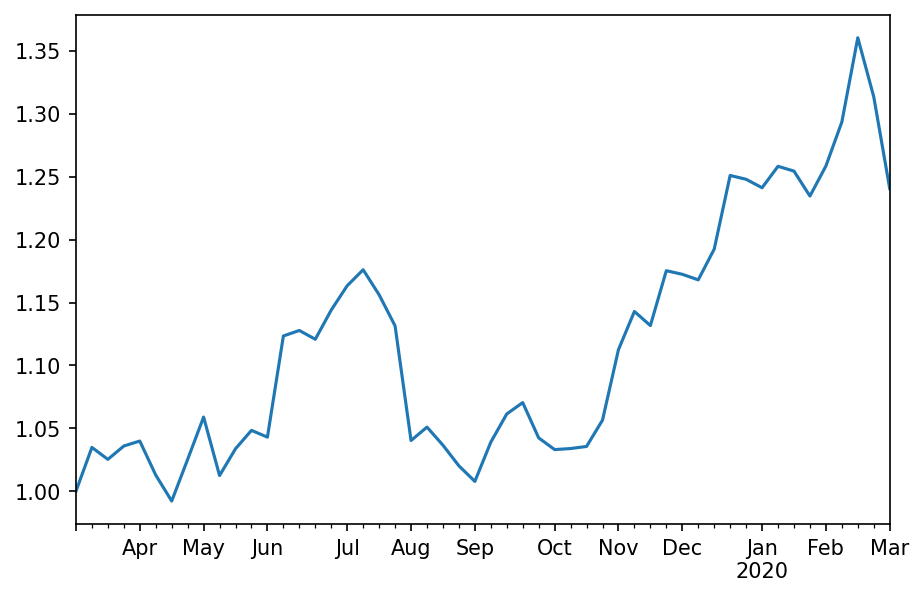

In [30]:
yearBacktest['Portfolio'].plot();

In [31]:
def getPortTimeSeries(y_withData, 
                      X, 
                      daily_stock_prices, 
                      ml_model_pipeline, 
                      verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 2009.
    Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    # This will be the start year, select stocks with publication within a 
    # time window, ending in March, when all annual reports are in.
    #dr=pd.date_range(start='2009-01-01', periods=10, freq='Y') 
    dr=pd.date_range(start='2009-01-01', 
                     periods=11, 
                     freq='Y') + pd.to_timedelta('9w') # start every March
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        annualResults = getPortTimeSeriesForYear(curr_date, 
                                                 y_withData, 
                                                 X,
                                                 daily_stock_prices, 
                                                 ml_model_pipeline)
        this_year_perf = annualResults["Portfolio"]
        ticker_list = list(annualResults.keys()[:-1])
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((annualResults[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Run a Backtest

In [32]:
daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (6567888, 11)


In [33]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
#trained_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))
#trained_model_pipeline = pickle.load(open("rfregressor.p", "rb" ))

trained_model_pipeline = pickle.load(open('pl_linear.p', 'rb' )) #rfregressor.p pl_linear.p

backTest = getPortTimeSeries(y_withData_Test, X_test, 
                             daily_stock_prices_data, 
                             trained_model_pipeline)

print('Overall performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2010-03-04 00:00:00  is: 5.78 %
With stocks: ['BIO', 'MAS', 'HCSG', 'NE', 'GRA', 'ATVI', 'AMGN']
BIO Performance was: 13.29 %
MAS Performance was: -10.03 %
HCSG Performance was: 18.3 %
NE Performance was: 0.23 %
GRA Performance was: 27.99 %
ATVI Performance was: 0.0 %
AMGN Performance was: -9.29 %
---------------------------------------------
Backtest performance for year starting  2011-03-04 00:00:00  is: 7.53 %
With stocks: ['ISIL', 'SNDK', 'DISH', 'ADS', 'VGR', 'AJRD', 'UIS']
ISIL Performance was: -7.73 %
SNDK Performance was: 4.82 %
DISH Performance was: 23.5 %
ADS Performance was: 50.67 %
VGR Performance was: 15.99 %
AJRD Performance was: 8.3 %
UIS Performance was: -42.83 %
---------------------------------------------
Backtest performance for year starting  2012-03-03 00:00:00  is: 35.41 %
With stocks: ['DNB', 'BKNG', 'DDD', 'IDCC', 'FII', 'REGN', 'MOS']
DNB Performance was: -1.07 %
BKNG Performance was: 6.54 %
DDD Performance was: 156.55 %

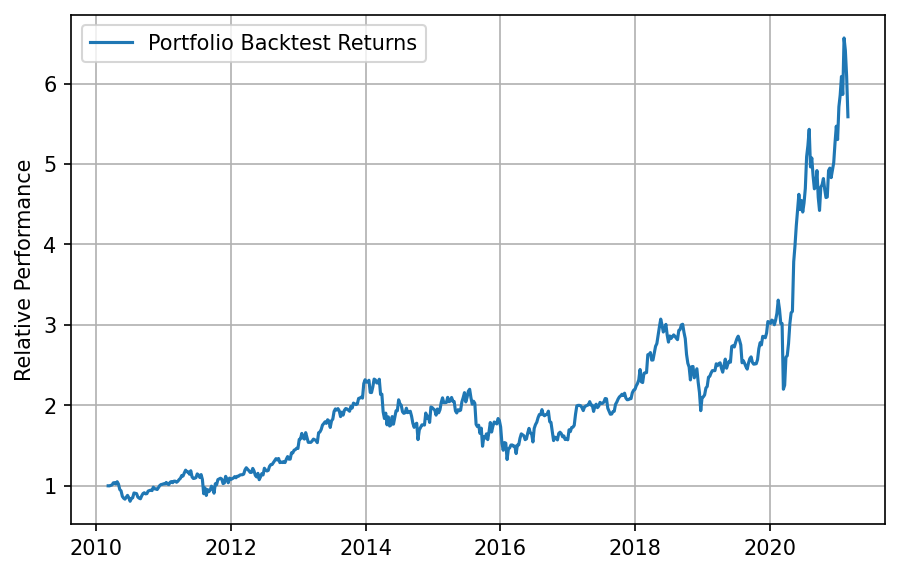

In [34]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

# Plot backtest with S&P500

In [35]:
backTest.index

DatetimeIndex(['2010-03-07', '2010-03-14', '2010-03-21', '2010-03-28',
               '2010-04-04', '2010-04-11', '2010-04-18', '2010-04-25',
               '2010-05-02', '2010-05-09',
               ...
               '2020-12-27', '2021-01-03', '2021-01-10', '2021-01-17',
               '2021-01-24', '2021-01-31', '2021-02-07', '2021-02-14',
               '2021-02-21', '2021-02-28'],
              dtype='datetime64[ns]', length=572, freq=None)

volatility of AI investor was:  0.7453353160633778
volatility of S&P 500 was:  0.3278946336652087


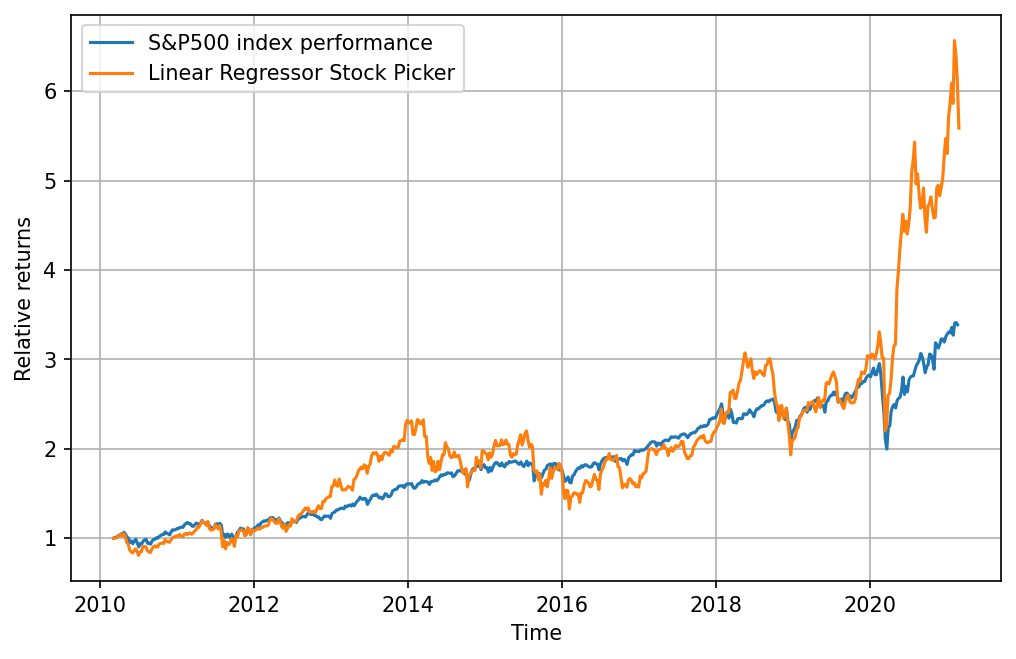

In [36]:
import pandas as pd
import pandas_datareader.data as pdr # Be sure this is installed from anaconda
from matplotlib import pyplot as plt

# Start and end dates
start = pd.to_datetime(backTest.index[0])
end = pd.to_datetime(backTest.index[-1])

# Use the Pandas DataReader
spy = pdr.DataReader('SPY', 'yahoo', start, end);
spy = spy.asfreq('W-MON', method='pad') # Weekly
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.plot(backTest)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])
#plt.savefig('spy.png')
print('volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

In [37]:
spy['Relative'][-1]

3.3875371111678083